In [2]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from numpy import arange
import numpy as np

In [11]:
colorsMap = {
    "prisma": "blue",
    "typeorm": "red",
    "sequelize": "black"
}


def plot_datasets(title, df1: pd.DataFrame, df2: pd.DataFrame, df3: pd.DataFrame):
    # create plot titles
    title_1 = df1.columns[0].split(" - ")[0]
    title_2 = df2.columns[0].split(" - ")[0]
    title_3 = df3.columns[0].split(" - ")[0]
    # create database labels
    db_1 = df3.columns[0].split(" - ")[1]
    db_2 = df3.columns[1].split(" - ")[1]
    db_3 = df3.columns[2].split(" - ")[1]


    # Create a figure with 3 subplots

    # max = df1.values.max()
    # if df2.values.max() > max:
    #     max = df2.values.max()
    # if df3.values.max() > max:
    #     max = df3.values.max()

    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    # fig, axs = plt.subplots(1, 3, figsize=(15,5), subplot_kw={'ylim': (0, max)})

    fig.suptitle(title, fontsize=16)

    # range = np.arange(min([df1.values, df2.values, df3.values]), max([df1.values, df2.values, df3.values])+1, 10)

    # Plot the first DataFrame on the first subplot
    axs[0].plot(df1.index, df1.values)
    axs[0].set_title(title_1, fontsize=12)
    axs[0].set_ylabel("Time in ms.")
    axs[0].hlines(xmin=0, xmax=len(df1.values), y=np.nanmean(df1), color='k', label='mean')

    # axs[0].axhline( y=np.nanmean(df1), color='k', linestyle='-', label="mean")
    # axs[0].set_xticks(range)

    # Plot the second DataFrame on the second subplot
    axs[1].plot(df2.index, df2.values)
    axs[1].set_title(title_2, fontsize=12)
    axs[1].set_xlabel("number of test")
    axs[1].hlines(xmin=0, xmax=len(df2.values), y=np.nanmean(df2), color='k', label='mean')
    # axs[1].set_xticks(range)

    # Plot the third DataFrame on the third subplot
    axs[2].plot(df3.index, df3.values)
    axs[2].set_title(title_3, fontsize=12)
    axs[2].hlines(xmin=0, xmax=len(df3.values), y=np.nanmean(df3), color='k', label='mean')
    axs[2].legend([db_1, db_2, db_3, "mean"], fontsize=12, bbox_to_anchor=(1, 1))

    # axs[2].axhline(y=np.nanmean(df3), color='k', linestyle='-', label='mean')
    # axs[2].set_xticks(range)

    # Adjust spacing between subplots
    plt.tight_layout()
    # Show the plot
    plt.show()



class CustomDataset:
    dir = "" # e.g. C:\workspace\orm\orm-client\result\create\create-customer-with-address-100
    path = "" # e.g. C:\workspace\orm\orm-client\result\create\create-customer-with-address-100\prisma.postgres.2023-03-21T11-47-30.csv
    csv_file_name = "" # e.g. prisma.postgres.2023-03-21T11-47-30.csv
    framework = "" # prisma | typeorm | sequelize
    db = "" # postgres | mysql | mssql
    method = "" # create | read | update | delete
    test_name = "" # e.g. create-customer-with-address-100
    df = None
    describe = None
    describeDf = None
    color = None

    def __init__(self, path, method, test_name, csv_file_name):
        self.dir = os.path.dirname(path)
        self.path = path
        self.method = method
        self.test_name = test_name
        self.csv_file_name = csv_file_name
        self.framework = csv_file_name.split(".")[0]
        self.db = csv_file_name.split(".")[1]
        self.df = read_csv(path, sep=";")
        self.color = colorsMap[self.framework]
        

    def create_describe(self):
        # create describe for time column
        self.describe = self.df["time"].describe()
        # create csv with describe values
        self.describe.to_csv(self.dir + "/" + self.csv_file_name + ".describe.csv", float_format="%.2f")
        # convert describe indexes to columns and create new dataframe
        self.describeDf = pd.DataFrame([self.describe[self.describe.index.values]], columns=self.describe.index.values, index=[self.get_framework_db_string()])

    def get_framework_db_string(self):
        return self.framework + " - " + self.db 








def summarize_custom_datasets_mean_values(custom_datasets: list[CustomDataset]):
    # Group CustomDatasets by framework and db
    group_dict: dict[str, list[CustomDataset]] = {}

    for dataset in custom_datasets:
        key = dataset.framework + "-" + dataset.db
        if key not in group_dict:
            group_dict[key] = []
        group_dict[key].append(dataset)

    means = {}

    # Calculate the mean value for each group and print the results
    for key, group in group_dict.items():
        mean_value = 0
        length = 0

        for custom_dataset in group:
            if 'mean' in custom_dataset.describe:
                mean_value += custom_dataset.describe["mean"]
                length += 1

        means[key] = mean_value / length

    for key in means:
        print(key + ": " + str(means[key]))








class CustomerConverter:
    custom_datasets: list[CustomDataset] = []
    custom_ds_map: dict[str, list[CustomDataset]] = {}
    grouped_custom_ds_map: dict[str, list[CustomDataset]]= {}
    groups_map = {}

    def convert(self, path):
        for file_path in glob.iglob(path + "/**/*.csv", recursive=True):
            if (file_path.find("describe") != -1):
                continue
            [result_dir, method, test_name, csv_file_name] = file_path.split("\\")
            dataset = CustomDataset(file_path,method,test_name,csv_file_name)
            self.custom_datasets.append(dataset)
        self.create_describe()
        self.group_datasets()

    def create_describe(self):
        for dataset in self.custom_datasets:
            dataset.create_describe()

    def group_datasets(self):
        for custom_dataset in self.custom_datasets:
            if custom_dataset.test_name not in self.custom_ds_map:
                self.custom_ds_map[custom_dataset.test_name] = []
            if custom_dataset.test_name + "-" + custom_dataset.framework not in self.grouped_custom_ds_map:
                self.grouped_custom_ds_map[custom_dataset.test_name + "-" + custom_dataset.framework] = []
            self.grouped_custom_ds_map[custom_dataset.test_name + "-" + custom_dataset.framework].append(custom_dataset)
            self.custom_ds_map[custom_dataset.test_name].append(custom_dataset)

    def create_describe_for_groups(self):
        for key, datasets in self.custom_ds_map.items():
            df = None
            for dataset in datasets:
                if df is None:
                    df = dataset.describeDf
                else:
                    df = df.append(dataset.describeDf)
            df.reset_index(inplace=True)
            df.rename(columns={'index': 'framework - db'}, inplace=True)
            df.reset_index()
            df = df.sort_values(by="50%", ascending=True)

            df.to_csv(datasets[0].dir +"/merged.describe.csv", float_format="%.2f")
            self.groups_map[key] = df
            print(key + "\n")
            format = "l" + "@{\hskip 12pt}" + 4 * "S[table-format = 2.2]"
            print(df.to_latex(index=False,position='h', float_format=lambda x: '%10.2f' % x))
            # print(df.head())

    def create_charts(self):

        # for test_name, datasets in self.test_name_to_datasets.items():
        #     test_name_to_times = {}
        #     colors = []
        #     for dataset in datasets:
        #         test_name_to_times[dataset.get_framework_db_string()] = dataset.df["time"]
        #         colors.append(dataset.color)
        #     df = pd.DataFrame(test_name_to_times)
        #     dfs.append(df)
        #     df.plot(fontsize=12,title=test_name, xticks=np.arange(min(df.index), max(df.index), 100), xlabel="number of test executions", ylabel="time in ms", figsize=(24,16))

        test_map: dict[str, list[CustomDataset]] = {}

        for key, custom_dataset in self.grouped_custom_ds_map.items():
            time_df_map = {}

            for dataset in custom_dataset:
                time_df_map[dataset.get_framework_db_string()] = dataset.df["time"]
            
            df = pd.DataFrame(time_df_map)

            test_name = custom_dataset[0].test_name
            if test_name not in test_map:
                test_map[test_name] = []
            test_map[test_name].append(df)
            # df.plot(fontsize=12,title=key, xticks=np.arange(min(df.index), max(df.index), 100), xlabel="number of test executions", ylabel="time in ms", figsize=(24,16))


        for test_name, dfs in test_map.items():
            if len(dfs) == 3:
                print(test_name)
                plot_datasets(test_name, dfs[0], dfs[1], dfs[2])




    def create_mean(self):
        summarize_custom_datasets_mean_values(self.custom_datasets)

converter = CustomerConverter()
converter.convert("C:/workspace/orm/orm-client/result")
converter.create_describe_for_groups()
converter.create_mean()








<ipython-input-11-1b472c2ef644>:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-11-1b472c2ef644>:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-11-1b472c2ef644>:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-11-1b472c2ef644>:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-11-1b472c2ef644>:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

create-customer-bulk-100000

\begin{table}[center]
\centering
\begin{tabular}{lrrrrrrrr}
\toprule
      framework - db &      count &       mean &        std &        min &        25\% &        50\% &        75\% &        max \\
\midrule
   sequelize - mysql &     100.00 &     370.40 &      29.47 &     318.67 &     347.19 &     366.95 &     389.21 &     452.42 \\
  typeorm - postgres &     100.00 &     400.55 &      13.50 &     380.76 &     390.48 &     397.38 &     407.58 &     442.30 \\
sequelize - postgres &     100.00 &     507.41 &      31.16 &     448.05 &     487.61 &     506.49 &     516.57 &     628.91 \\
   prisma - postgres &     100.00 &     703.38 &      41.93 &     631.02 &     670.96 &     700.35 &     733.23 &     815.67 \\
     typeorm - mysql &     100.00 &     702.80 &      22.32 &     659.69 &     687.62 &     701.15 &     716.99 &     771.02 \\
      prisma - mysql &     100.00 &     756.98 &      45.23 &     625.37 &     729.62 &     751.70 &     775.29 &     905.

<ipython-input-11-1b472c2ef644>:189: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False,position='center', float_format=lambda x: '%10.2f' % x))
<ipython-input-11-1b472c2ef644>:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-11-1b472c2ef644>:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-11-1b472c2ef644>:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.c

create-product-1000000

\begin{table}[center]
\centering
\begin{tabular}{lrrrrrrrr}
\toprule
      framework - db &      count &       mean &        std &        min &        25\% &        50\% &        75\% &        max \\
\midrule
  typeorm - postgres &    1000.00 &       2.38 &       0.25 &       2.05 &       2.23 &       2.34 &       2.47 &       4.50 \\
sequelize - postgres &    1000.00 &       2.76 &       1.59 &       2.19 &       2.50 &       2.66 &       2.86 &      51.43 \\
   prisma - postgres &    1000.00 &       3.94 &       0.36 &       3.13 &       3.70 &       3.93 &       4.15 &       6.59 \\
     typeorm - mysql &    1000.00 &       5.91 &       0.96 &       4.37 &       5.29 &       5.75 &       6.30 &      15.59 \\
      prisma - mysql &    1000.00 &       5.87 &       0.84 &       4.55 &       5.33 &       5.76 &       6.27 &      17.89 \\
   sequelize - mysql &    1000.00 &       5.94 &       1.07 &       4.34 &       5.09 &       5.80 &       6.51 &      12.42 \\

<ipython-input-11-1b472c2ef644>:189: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False,position='center', float_format=lambda x: '%10.2f' % x))
<ipython-input-11-1b472c2ef644>:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-11-1b472c2ef644>:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-11-1b472c2ef644>:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.c

delete-order-500000

\begin{table}[center]
\centering
\begin{tabular}{lrrrrrrrr}
\toprule
      framework - db &      count &       mean &        std &        min &        25\% &        50\% &        75\% &        max \\
\midrule
     typeorm - mysql &    1000.00 &       4.58 &       0.88 &       3.31 &       3.93 &       4.49 &       4.99 &      10.85 \\
   sequelize - mysql &    1000.00 &       5.41 &       1.01 &       3.81 &       4.83 &       5.36 &       5.81 &      17.22 \\
      prisma - mysql &    1000.00 &       6.19 &       1.91 &       4.55 &       5.60 &       6.07 &       6.53 &      60.11 \\
  typeorm - postgres &    1000.00 &      64.86 &       5.03 &      60.08 &      61.85 &      62.66 &      66.30 &     129.20 \\
sequelize - postgres &    1000.00 &      70.06 &       3.17 &      60.94 &      68.62 &      70.08 &      71.72 &      81.55 \\
   prisma - postgres &    1000.00 &      81.44 &       5.30 &      67.76 &      79.11 &      81.38 &      83.19 &      94.85 \\
  

<ipython-input-11-1b472c2ef644>:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-11-1b472c2ef644>:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-11-1b472c2ef644>:179: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dataset.describeDf)
<ipython-input-11-1b472c2ef644>:189: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False,posit

read-product-500000

\begin{table}[center]
\centering
\begin{tabular}{lrrrrrrrr}
\toprule
      framework - db &      count &       mean &        std &        min &        25\% &        50\% &        75\% &        max \\
\midrule
  typeorm - postgres &    1000.00 &       0.91 &       0.74 &       0.73 &       0.82 &       0.86 &       0.93 &      23.88 \\
     typeorm - mysql &    1000.00 &       0.99 &       0.13 &       0.81 &       0.90 &       0.96 &       1.06 &       2.11 \\
sequelize - postgres &    1000.00 &       1.06 &       0.25 &       0.83 &       0.95 &       1.02 &       1.11 &       4.22 \\
   sequelize - mysql &    1000.00 &       1.32 &       0.18 &       1.08 &       1.21 &       1.29 &       1.38 &       3.14 \\
      prisma - mysql &    1000.00 &       1.47 &       0.56 &       1.23 &       1.35 &       1.42 &       1.52 &      18.54 \\
      prisma - mssql &    1000.00 &       1.68 &       0.18 &       1.43 &       1.57 &       1.65 &       1.74 &       3.86 \\
  

create-customer-bulk-100000


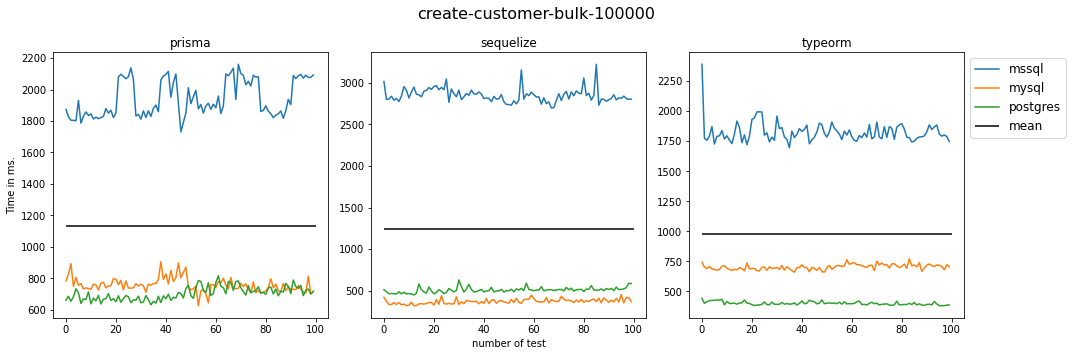

create-customer-bulk-1000000


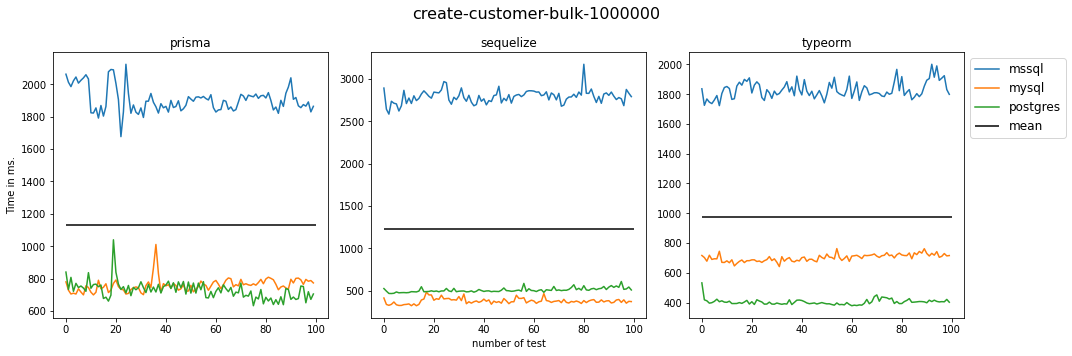

create-customer-bulk-500000


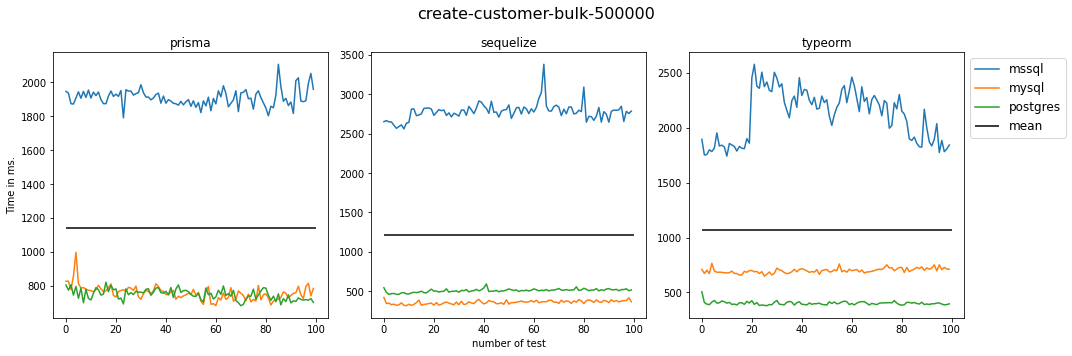

create-customer-with-address-100000


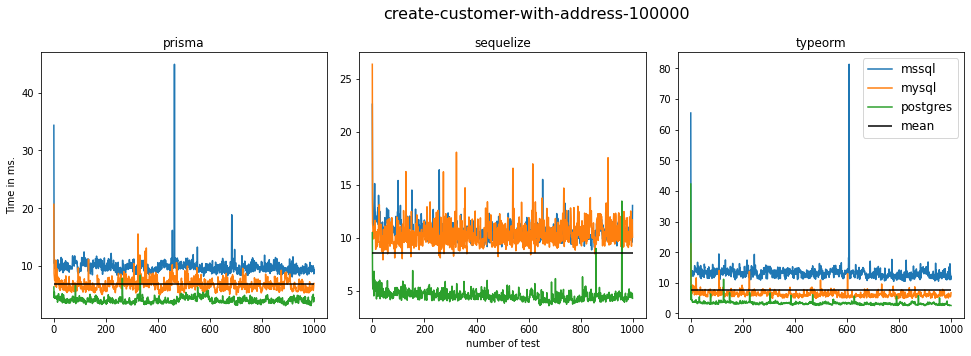

create-customer-with-address-1000000


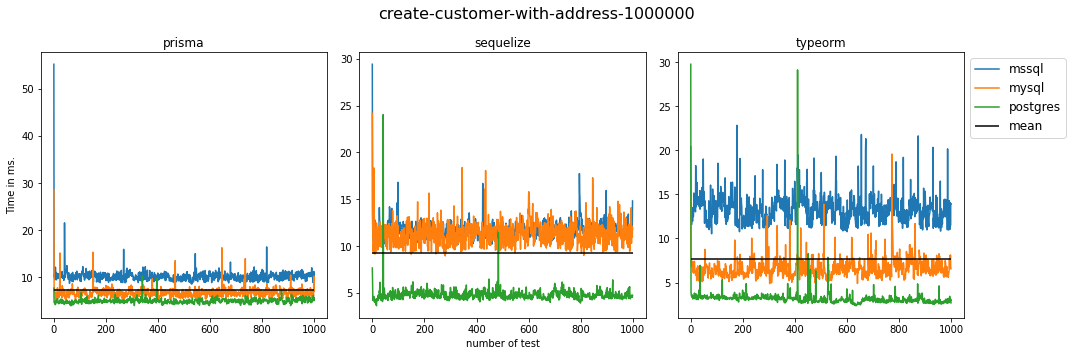

create-customer-with-address-500000


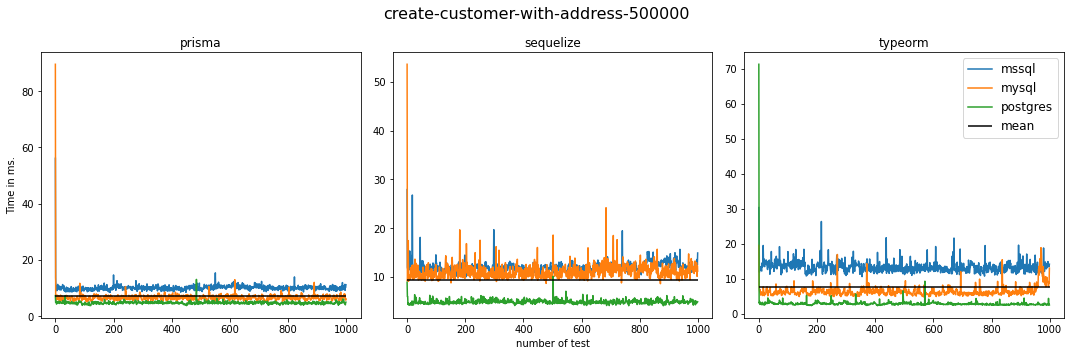

create-order-100000


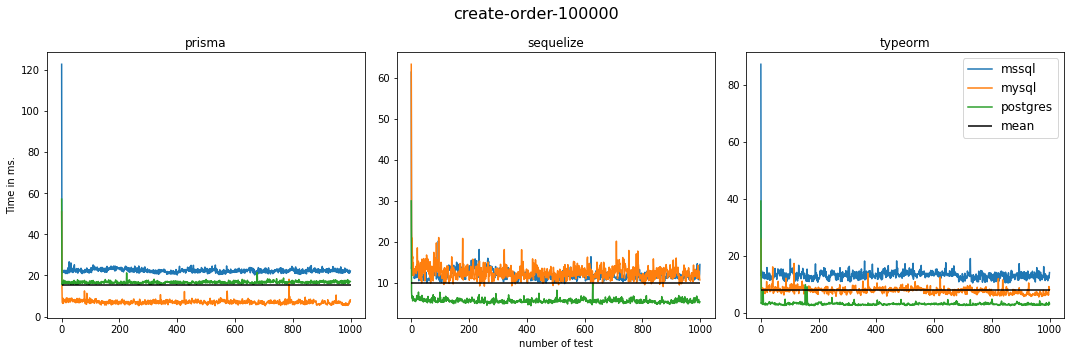

create-order-1000000


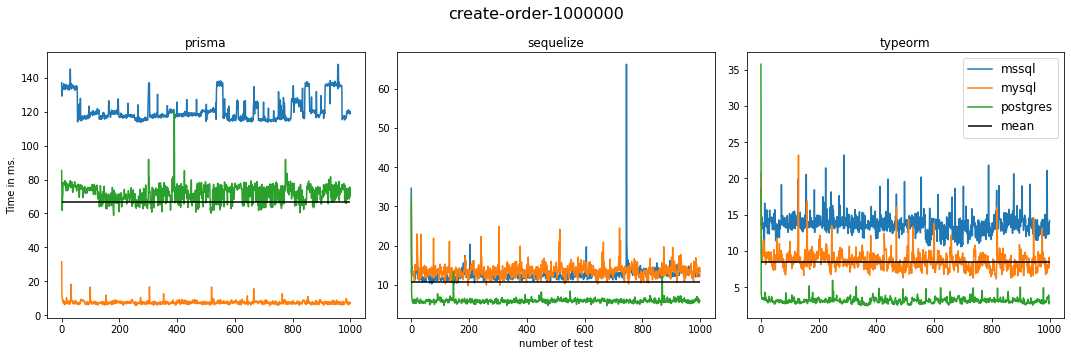

create-order-500000


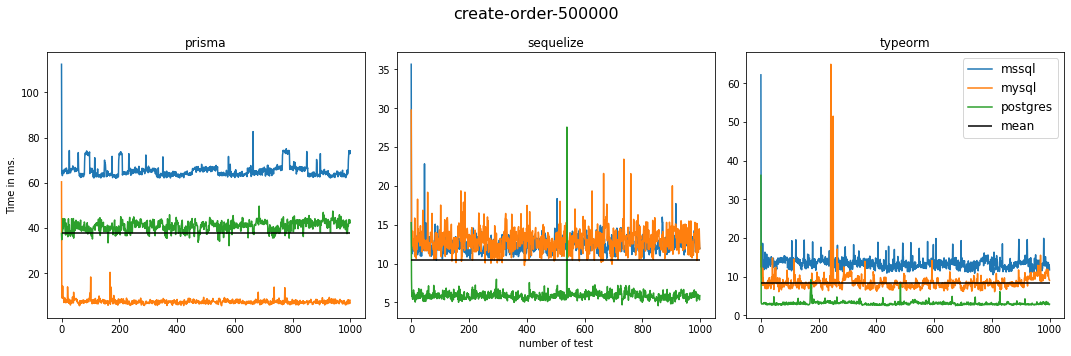

create-product-100000


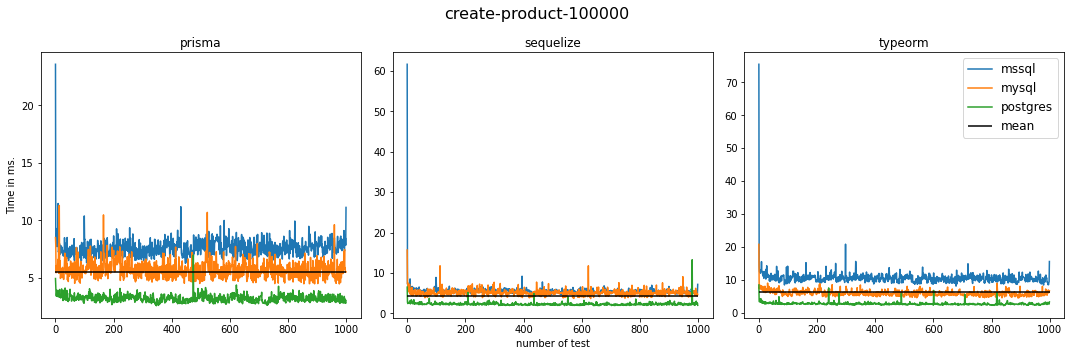

create-product-1000000


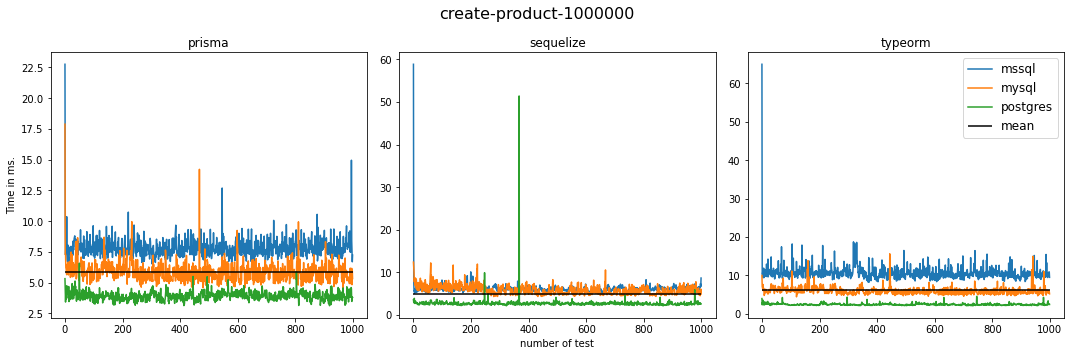

create-product-500000


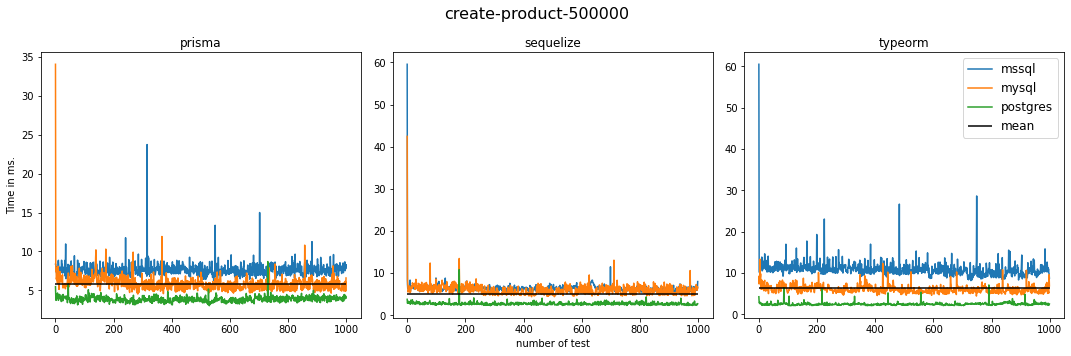

delete-customer-100000


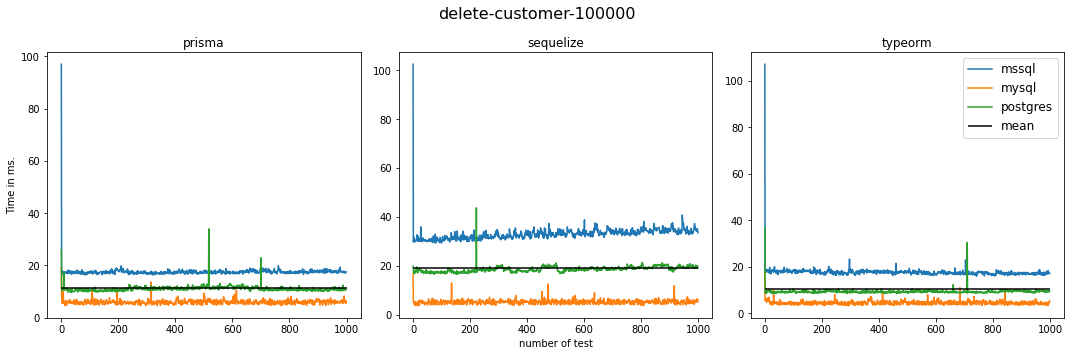

delete-customer-1000000


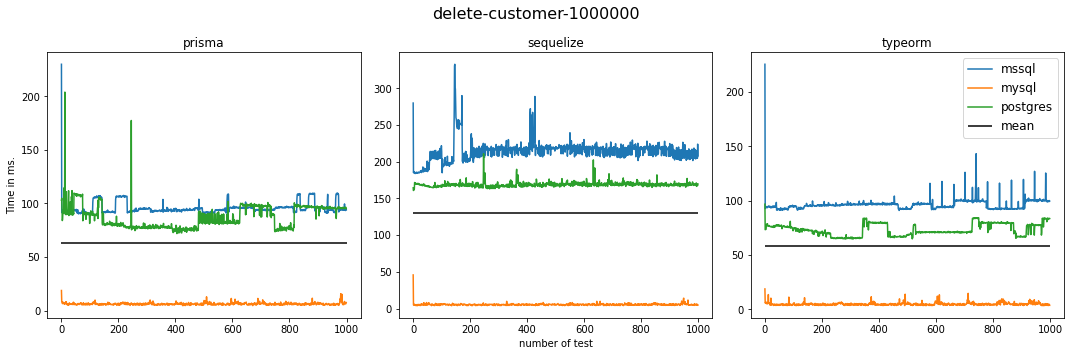

delete-customer-500000


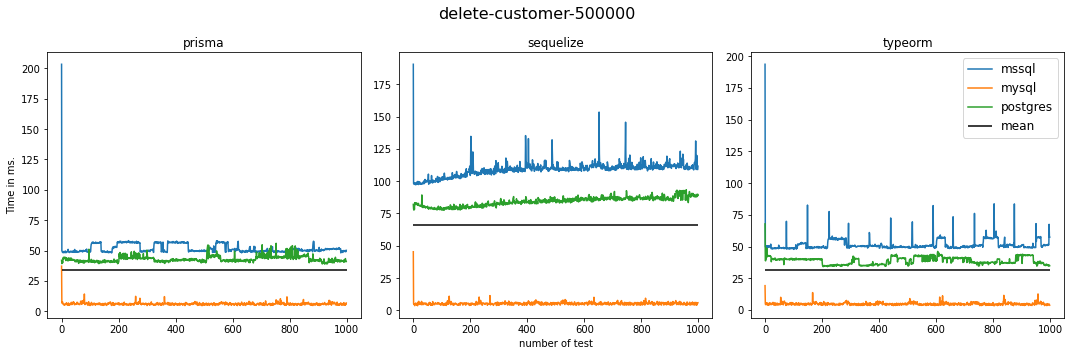

delete-order-100000


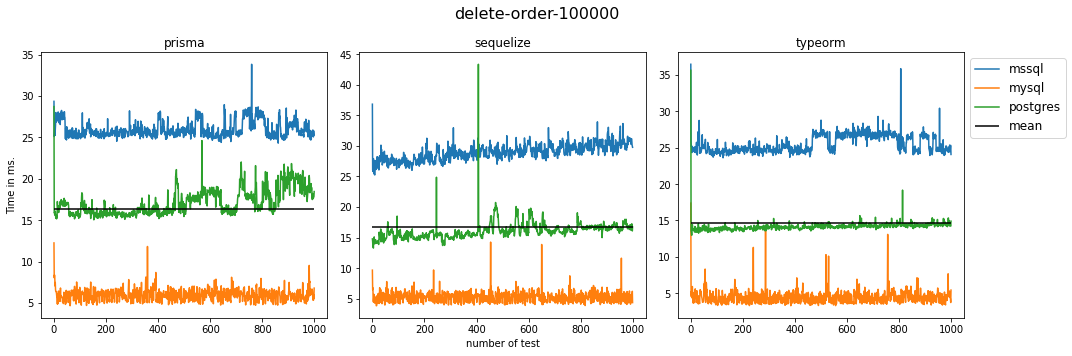

delete-order-1000000


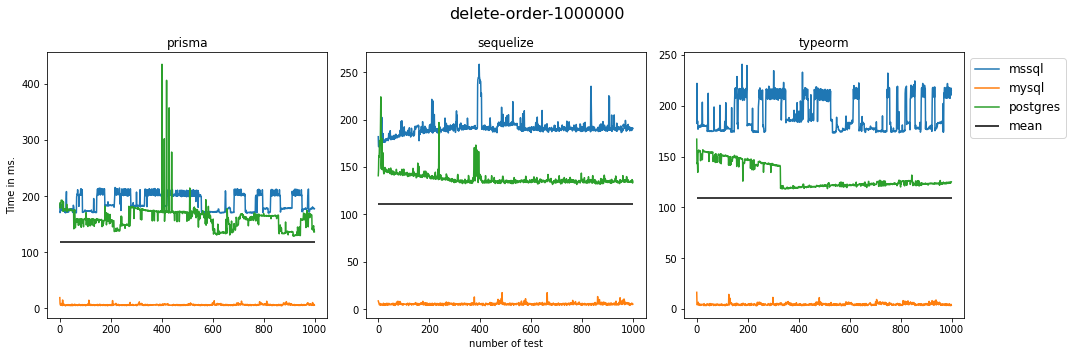

delete-order-500000


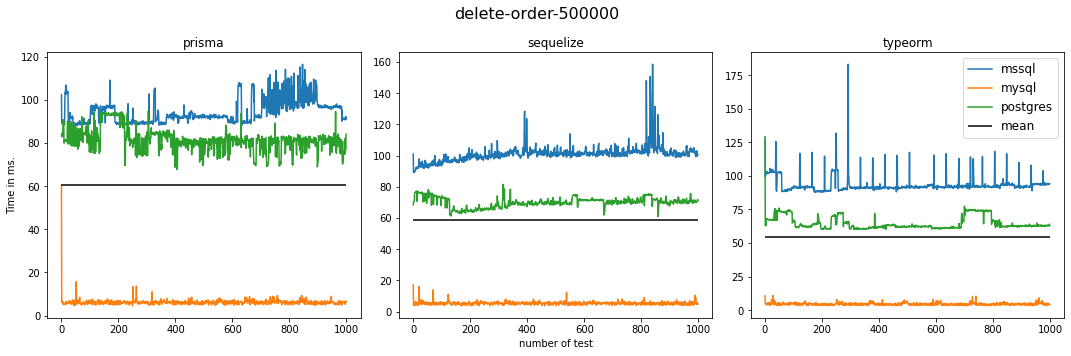

read-customer-orders-100000


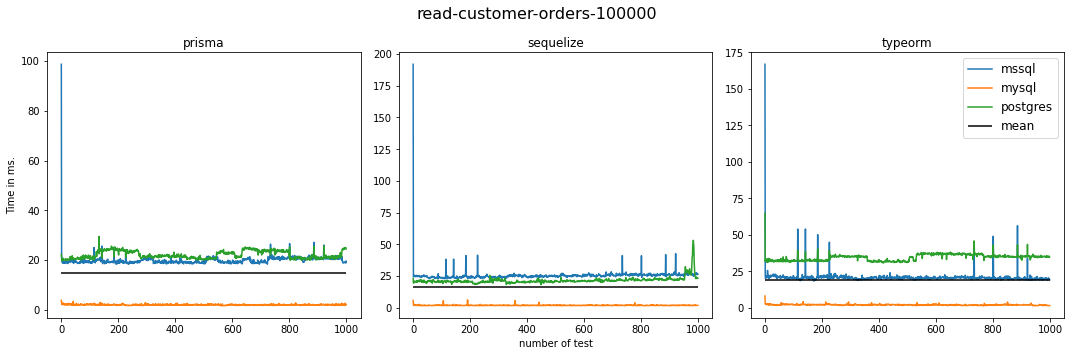

read-customer-orders-1000000


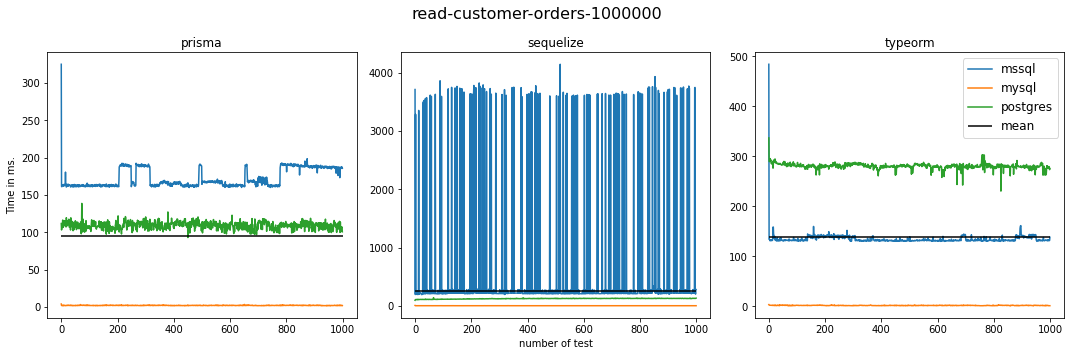

read-customer-orders-500000


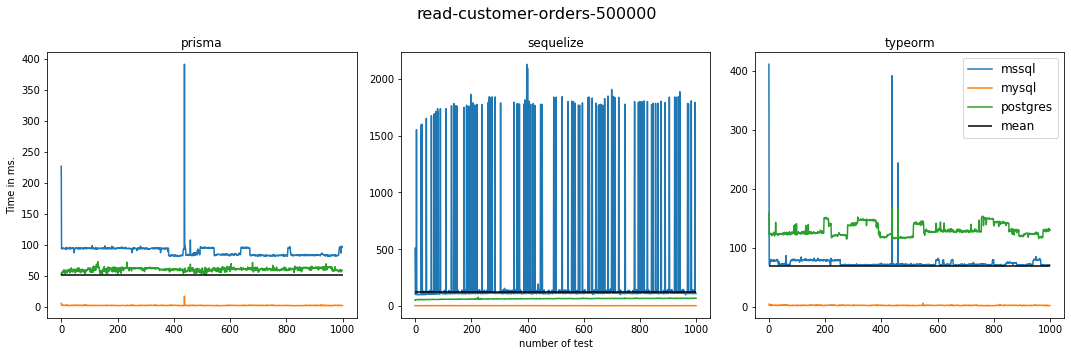

read-customer-products-100000


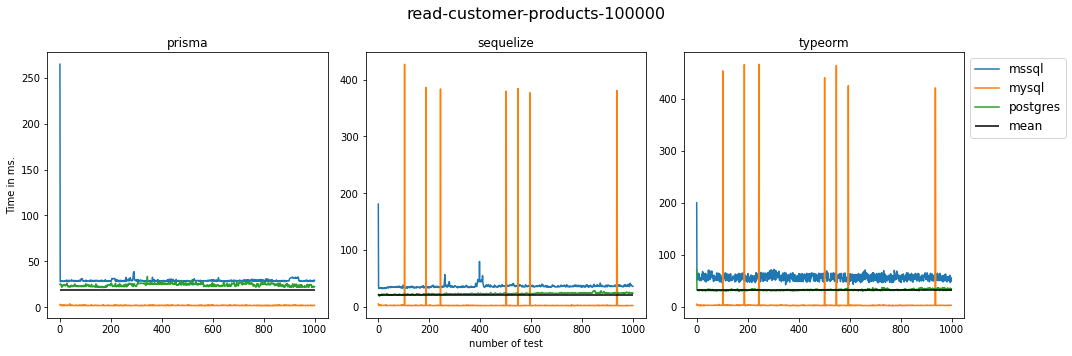

read-customer-products-1000000


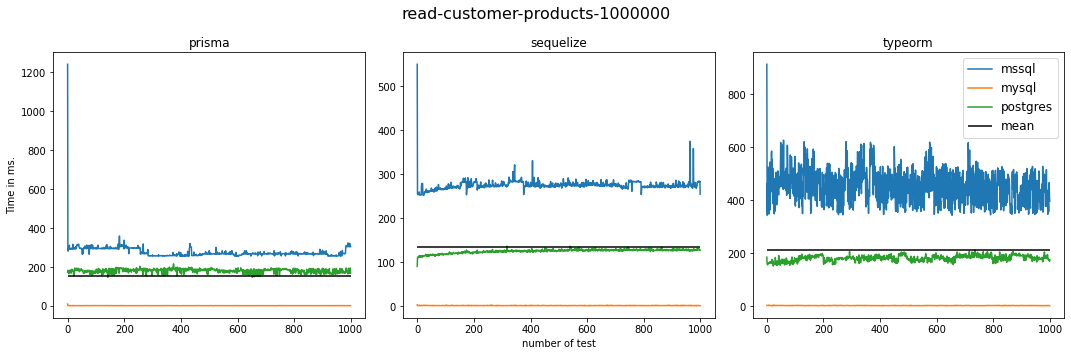

read-customer-products-500000


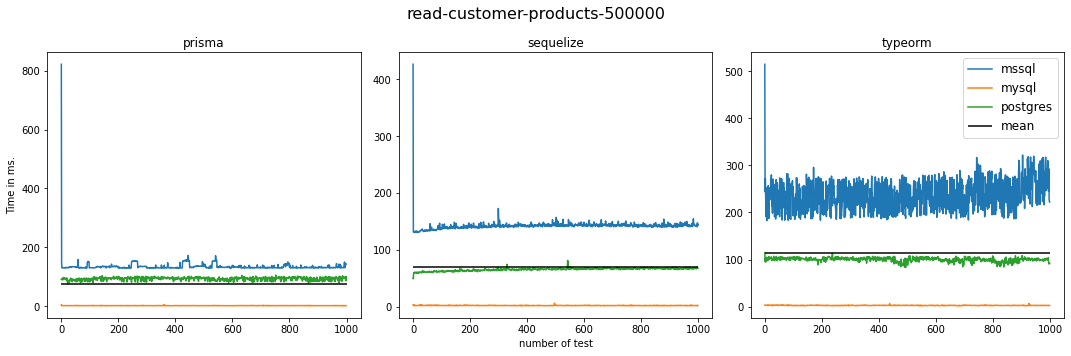

read-product-100000


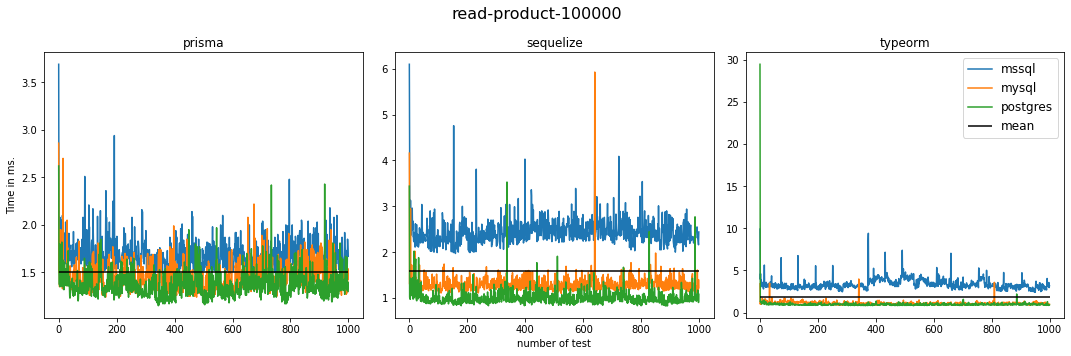

read-product-1000000


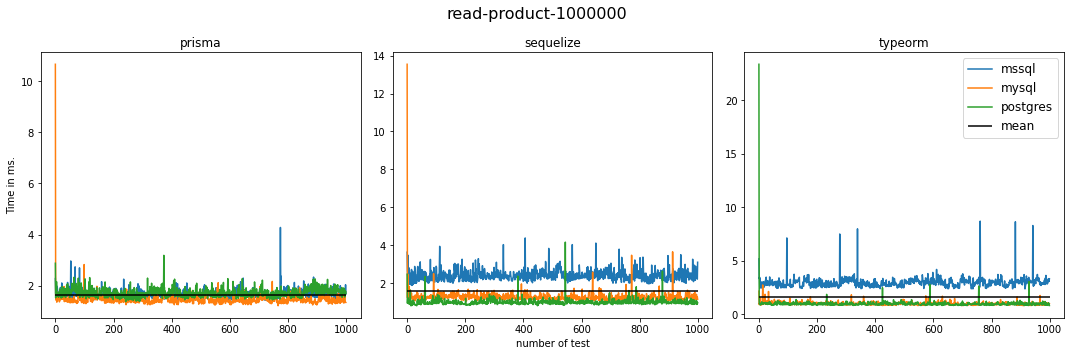

read-product-500000


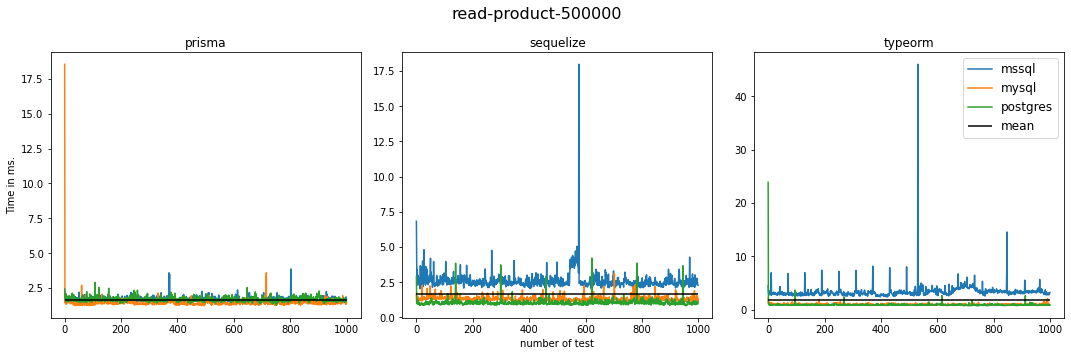

read-products-from-category-100000


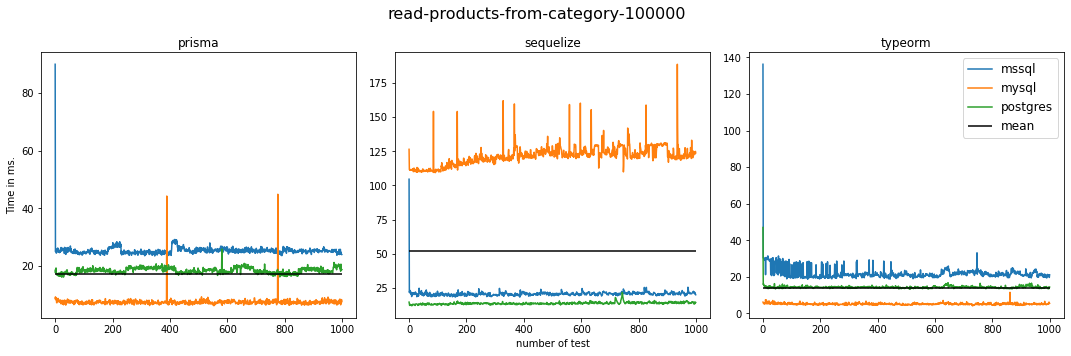

read-products-from-category-1000000


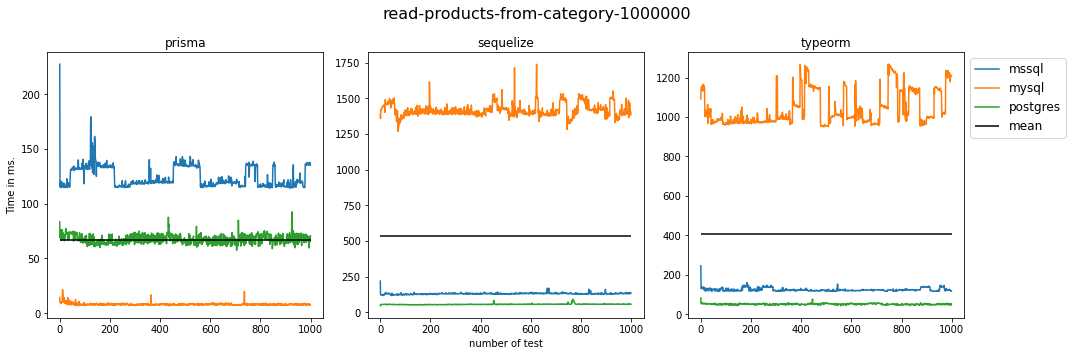

read-products-from-category-500000


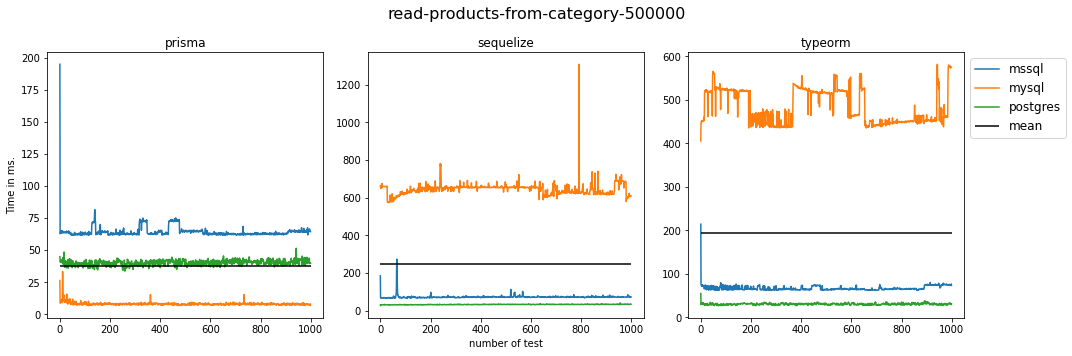

update-customer-phone-number-100000


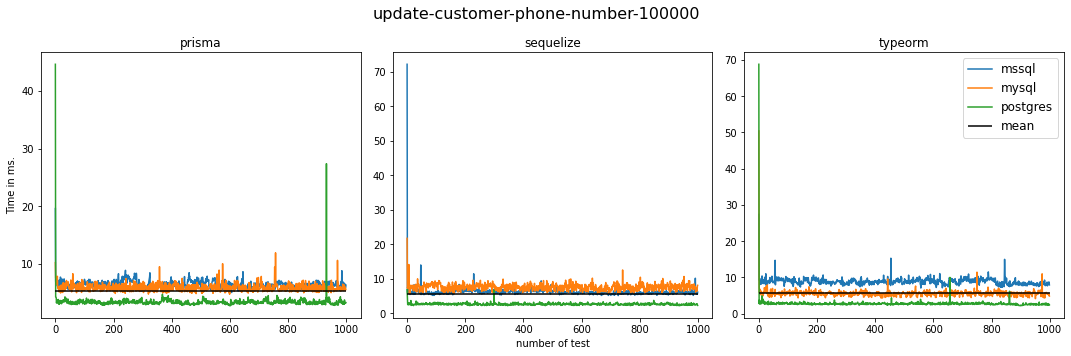

update-customer-phone-number-1000000


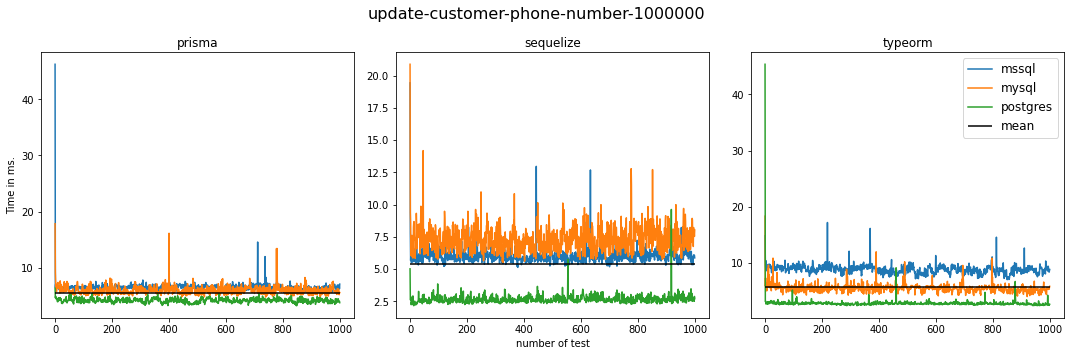

update-customer-phone-number-500000


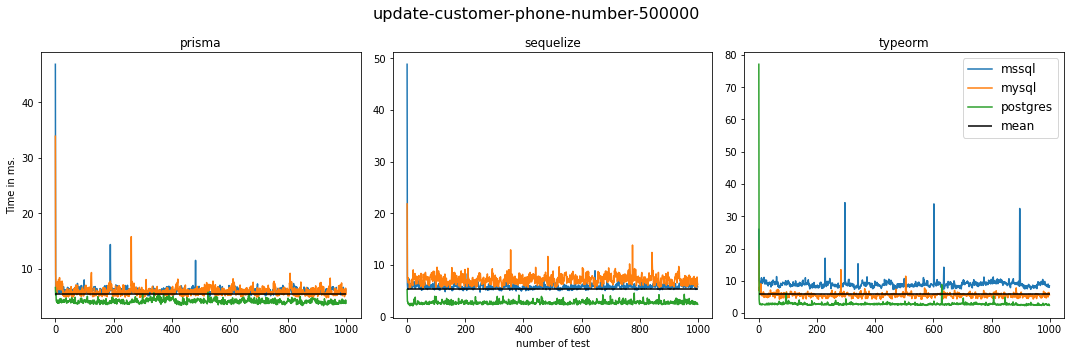

update-product-category-name-100000


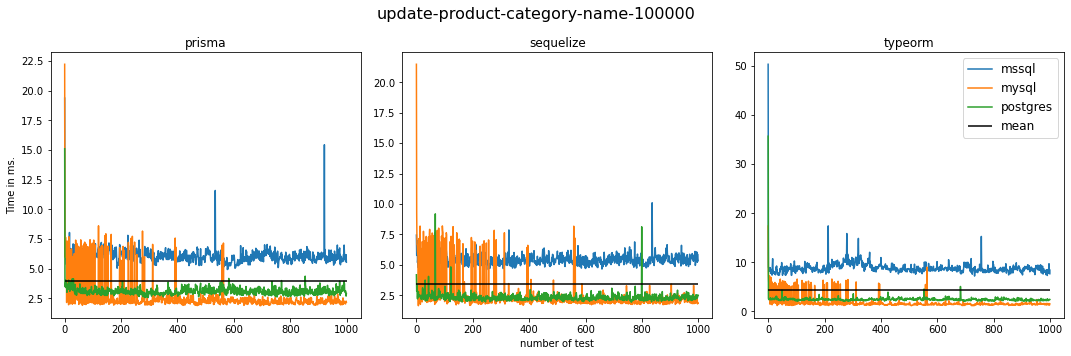

update-product-category-name-1000000


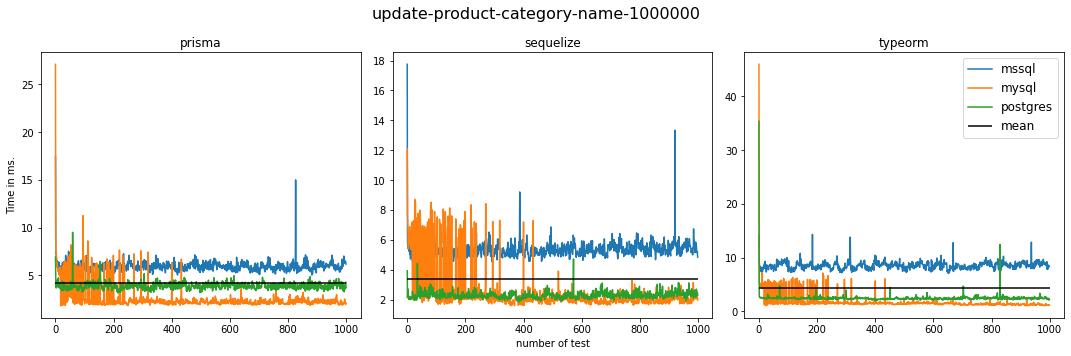

update-product-category-name-500000


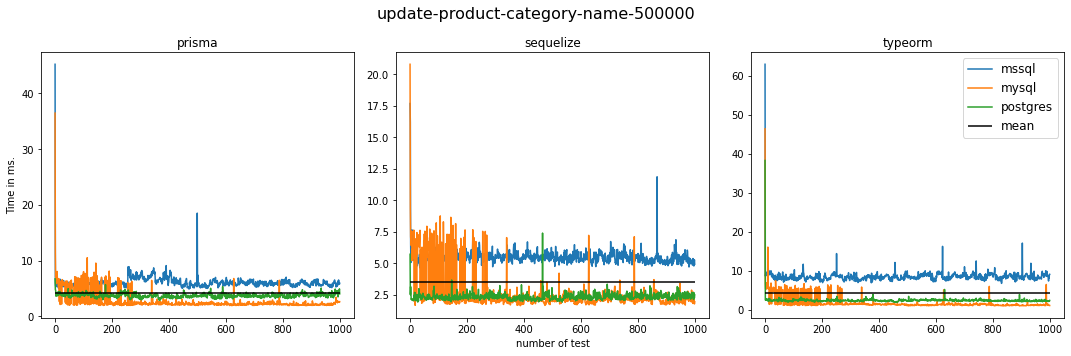

In [4]:
converter.create_charts()

In [5]:
dffff.values

NameError: name 'dffff' is not defined